# Direct Optimal Control Plotting

In [1]:
import sys; sys.path.append(2*'../') # go n dirs back
from src import *

# Change device according to your configuration
# device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu') # feel free to change :)

In [2]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

## Optimal Control

We want to control an inverted pendulum and stabilize it in the upright position. The equations in Hamiltonian form describing an inverted pendulum with a torsional spring are as following:

$$\begin{equation}
    \begin{bmatrix} \dot{q}\\ \dot{p}\\ \end{bmatrix} = 
    \begin{bmatrix}
    0& 1/m \\
    -k& -\beta/m\\
    \end{bmatrix}
    \begin{bmatrix} q\\ p\\ \end{bmatrix} -
    \begin{bmatrix}
    0\\
    mgl \sin{q}\\
    \end{bmatrix}+
    \begin{bmatrix}
    0\\
    1\\
    \end{bmatrix} u
\end{equation}$$

In [3]:
class ControlledPendulum(nn.Module):
    """
    Inverted pendulum with torsional spring
    """
    def __init__(self, u, m=1., k=.5, l=1., qr=0., β=.01, g=9.81):
        super().__init__()
        self.u = u # controller (nn.Module)
        self.nfe = 0 # number of function evaluations
        self.cur_f = None # current function evaluation
        self.cur_u = None # current controller evaluation 
        self.m, self.k, self.l, self.qr, self.β, self.g = m, k, l, qr, β, g # physics
        
    def forward(self, t, x):
        self.nfe += 1
        q, p = x[..., :1], x[..., 1:]
        self.cur_u = self.u(t, x)
        dq = p/self.m
        dp = -self.k*(q - self.qr) - self.m*self.g*self.l*torch.sin(q) \
            -self.β*p/self.m + self.cur_u
        self.cur_f = torch.cat([dq, dp], -1)
        return self.cur_f

from math import pi as π
x_star = torch.Tensor([0., 0.]).to(device)
cost_func = IntegralCost(x_star, P=1, Q=1) # final position is more important

# Time span
dt = 0.2
t0, tf = 0, 3 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)


In [4]:
u_euler = torch.load('saved_models/u_euler.pt')
u_hyper = torch.load('saved_models/u_hyper.pt')
u_mp = torch.load('saved_models/u_mp.pt')
u_rk4 = torch.load('saved_models/u_rk4.pt')

tensor(3.3131, grad_fn=<AddBackward0>) tensor(0.6664, grad_fn=<AddBackward0>) tensor(0.6505, grad_fn=<AddBackward0>) tensor(0.6426, grad_fn=<AddBackward0>)


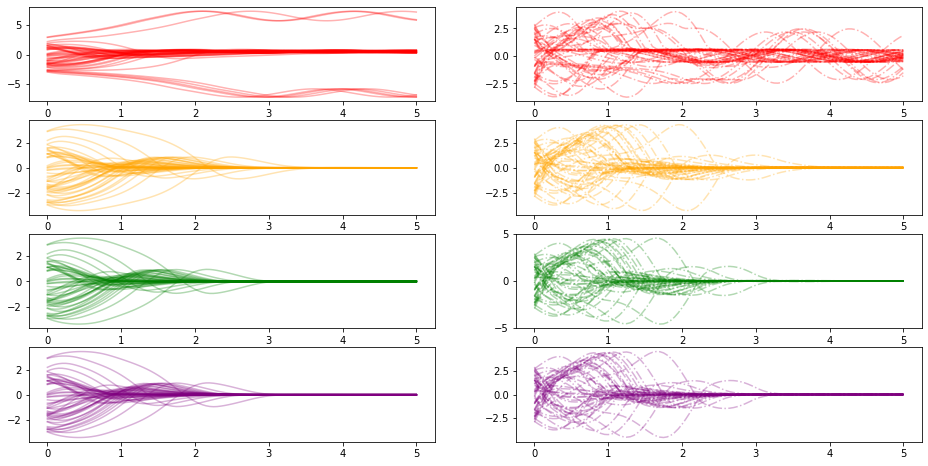

In [5]:
# Testing the controller on the real system
frac = 0.95
init_dist = torch.distributions.Uniform(torch.Tensor([-frac*π, -frac*π]), torch.Tensor([frac*π, frac*π]))
x0 = init_dist.sample((50,)).to(device)
t0, tf, steps = 0, 5, 10*10 + 1 # nominal trajectory
t_span_fine = torch.linspace(t0, tf, steps).to(device)
sys = ControlledPendulum(None)

sys.u = u_euler; _, traj_eu = odeint(sys, x0, t_span_fine, solver='tsit5', atol=1e-5, rtol=1e-5)
sys.u = u_hyper; _, traj_hyper = odeint(sys, x0, t_span_fine, solver='tsit5', atol=1e-5, rtol=1e-5)
sys.u = u_mp; _, traj_mp = odeint(sys, x0, t_span_fine, solver='tsit5', atol=1e-5, rtol=1e-5)
sys.u = u_rk4; _, traj_rk4 = odeint(sys, x0, t_span_fine, solver='tsit5', atol=1e-5, rtol=1e-5)

print(cost_func(traj_eu), cost_func(traj_hyper), cost_func(traj_mp), cost_func(traj_rk4))

t_span_fine = t_span_fine.detach().cpu()
traj_eu, traj_hyper, traj_mp, traj_rk4 = traj_eu.detach().cpu(), traj_hyper.detach().cpu(), traj_mp.detach().cpu(), traj_rk4.detach().cpu()

# Plotting
fig, axs = plt.subplots(4, 2, figsize=(16,8))
for i in range(len(x0)):
    axs[0,0].plot(t_span_fine, traj_eu[:,i,0], 'r', alpha=.3, label='p' if i==0 else None)
    axs[0,1].plot(t_span_fine, traj_eu[:,i,1], 'r-.', alpha=.3, label='q' if i==0 else None)
    axs[1,0].plot(t_span_fine, traj_hyper[:,i,0], color='orange', alpha=.3, label='p' if i==0 else None)
    axs[1,1].plot(t_span_fine, traj_hyper[:,i,1], color='orange', linestyle='-.', alpha=.3, label='q' if i==0 else None)
    axs[2,0].plot(t_span_fine, traj_mp[:,i,0], color='green', alpha=.3, label='p' if i==0 else None)
    axs[2,1].plot(t_span_fine, traj_mp[:,i,1], color='green', linestyle='-.', alpha=.3, label='q' if i==0 else None)
    axs[3,0].plot(t_span_fine, traj_rk4[:,i,0], color='purple', alpha=.3, label='p' if i==0 else None)
    axs[3,1].plot(t_span_fine, traj_rk4[:,i,1], color='purple', linestyle='-.', alpha=.3, label='q' if i==0 else None)
    
# ax.legend()
# ax.set_title('Controlled trajectories')
# ax.set_xlabel(r"$t~[s]$")

Great 🎉

Training the controller with `HyperEuler` resulted in a working controller stabilizing the system in the given time; more importantly, while in the first part we used a high accuracy solver to obtain similar results training with the same number of epochs and all the same hyperparameters but using the hypersolver took less than time than higher-order solvers! Now, let's see the results

In [6]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

HyperEuler  loss:
 0.662048876285553
HyperEuler  error mean: tensor(0.0103)   error_std:  tensor(0.0005)
Euler  loss:
 3.3110783100128174
Euler  error mean: tensor(0.3847)   error_std:  tensor(2.1806)
Midpoint  loss:
 0.6460438966751099
Midpoint  error mean: tensor(-0.0099)   error_std:  tensor(3.8186e-05)
RK4  loss:
 0.6380420327186584
RK4  error mean: tensor(0.0073)   error_std:  tensor(6.1961e-05)


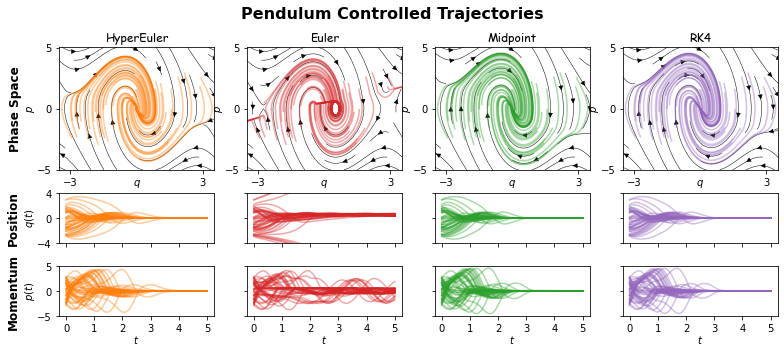

In [7]:
# Cool plots

from matplotlib import colors, cm
import matplotlib.gridspec as gridspec

norm = colors.Normalize(vmin=0, vmax=16)

controller = [u_hyper, u_euler, u_mp, u_rk4]
colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:purple']
labels = ['HyperEuler', 'Euler', 'Midpoint', 'RK4']
cmap='bone'
titles = ['HyperEuler', 'Euler', 'Midpoint', 'RK4']
sys = []

fig = plt.figure(figsize=(11,5), constrained_layout=False)
spec = gridspec.GridSpec(ncols=4, nrows=8, figure=fig)


# Time span
t0, tf = 0, 5 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps*20).to(device) # nominal

lim = π
graph_lim = lim*1.6
# x0 = torch.Tensor(50, 2).uniform_(-lim, lim).to(device)
x0_test = init_dist.sample((1000,)).to(device) # test on 1000 trajectories from random points
axs = []
axs_q, axs_p = [], []
for i in range(4):
    axs.append(fig.add_subplot(spec[:4, i]))
    axs_q.append(fig.add_subplot(spec[4:6, i]))
    axs_p.append(fig.add_subplot(spec[6:8, i])) #, sharex=axs_q[-1]


for u, ax, i in zip(controller, axs, range(len(controller))):
    sys.append(ControlledPendulum(u).to(device))
    n_grid = 50
    x = torch.linspace(-graph_lim, graph_lim, n_grid).to(device)
    Q, P = torch.meshgrid(x, x) ; z = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], 1)
    f = sys[-1](0, z).detach().cpu()
    Fq, Fp = f[:,0].reshape(n_grid, n_grid), f[:,1].reshape(n_grid, n_grid)
    val = sys[-1].u(0, z).detach().cpu()
    U = val.reshape(n_grid, n_grid)
    ax.streamplot(Q.T.detach().cpu().numpy(), P.T.detach().cpu().numpy(),
                  Fq.T.detach().cpu().numpy(), Fp.T.detach().cpu().numpy(), color='black', density=0.6, linewidth=0.5)
    
    ax.set_xlim([-graph_lim*0.7, graph_lim*0.7]) ; ax.set_ylim([-graph_lim, graph_lim])
    traj = odeint(sys[-1], x0, t_span,  solver='dopri5')[1].detach().cpu()
    for j in range(traj.shape[1]):
        ax.plot(traj[:,j,0], traj[:,j,1], c=colors[i], alpha=.4, label=labels[i] if j==0 else "")
        axs_q[i].plot(t_span, traj[:,j,0], c=colors[i], alpha=.4)
        axs_p[i].plot(t_span, traj[:,j,1], c=colors[i], alpha=.4)

    traj_test = odeint(sys[-1], x0_test, t_span,  solver='dopri5')[1].detach().cpu()
    print(titles[i], ' loss:\n', cost_func(traj.to(device)).item())
    distance_mean, distance_std = traj_test[-1,:,0].mean(), traj_test[-1,...,0].std()
    # Not actually "error", this the mean value of positions and std
    print(titles[i], ' error mean:', distance_mean, '  error_std: ', distance_std)
    
    ax.set_xlabel(r'$q$',  labelpad=-10)
    ax.set_ylabel(r'$p$',  labelpad=0)
    ax.set_xticks([-3,  3])
    ax.set_yticks([-5,  0, 5])
    ax.set_title(titles[i], family='cursive')
    
plt.suptitle('Pendulum Controlled Trajectories',fontsize=16, weight='bold', y=0.97)


axs_q[0].set_ylabel(r'$q(t)$', labelpad=0)
axs_p[0].set_ylabel(r'$p(t)$', labelpad=0)
for axq, axp in zip(axs_q, axs_p):
    axq.set_xticks([0, 1, 2, 3, 4, 5])
    axp.set_xticks([0, 1, 2, 3, 4, 5])
    axp.set_xlabel(r'$t$',  labelpad=0)
    axq.tick_params(labelbottom=False)    
    axq.set_yticks([-4, 0, 4])
    axp.set_yticks([-5, 0, 5])
    axq.set_ylim([-4, 4])
    axp.set_ylim([-5, 5])
    
axs_q[0].set_yticks([-4, 0, 4])
axs_p[0].set_yticks([-5, 0, 5])

for i in range(1, 4, 1):
    axs_q[i].tick_params(labelleft=False)
    axs_p[i].tick_params(labelleft=False)

pad = 3
axs[0].annotate("Phase Space", xy=(0, 0.5), xytext=(-axs[0].yaxis.labelpad - pad, 0),
                xycoords=axs[0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation='vertical', fontweight='bold')

axs_q[0].annotate("Position", xy=(0, 0.5), xytext=(-axs_q[0].yaxis.labelpad - pad, 0),
                xycoords=axs_q[0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation='vertical', fontweight='bold')

axs_p[0].annotate("Momentum", xy=(0, 0.5), xytext=(-axs_p[0].yaxis.labelpad - pad, 0),
                xycoords=axs_p[0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(h_pad=0, w_pad=-0.1)

# Saving
# import tikzplotlib
fig.savefig('media/pendulum_control.pdf',  bbox_inches = 'tight')
# tikzplotlib.save("media/pendulum_control.tex")

## Calculating MACs and plotting losses
We can use the number of MACs instead of NFEs so we obtain a simpler

In [8]:
from ptflops import get_model_complexity_info

bs = 1024 # batch size we used in training
def get_macs(net:nn.Module):
    params = []
    for p in net.parameters(): params.append(p.shape)
    with torch.cuda.device(0):
        macs, _ = get_model_complexity_info(net, (bs, params[0][1]), as_strings=False)
    return int(macs)

In [ ]:

controller = nn.Sequential(
                nn.Linear(2, 64),
                nn.Softplus(),
                nn.Linear(64, 64),
                nn.Softplus(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1))

hypersolver = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 1)).to(device)

hs_macs = get_macs(hypersolver)
u_macs = get_macs(controller)
print('Controller MACs per NFE:', u_macs, '\nHypersolver MACs per NFE:', hs_macs)

In [ ]:
unit_mac_hyper = u_macs + hs_macs
unit_mac_euler = u_macs
unit_mac_midpoint = u_macs*2 # midpoint has to evaluate the vector field twice per NFE
unit_mac_rk4 = u_macs*4 # rk4 has to do it 4 times

In [ ]:
multiplier = 2 # mac to flops
macs_hyper = unit_mac_hyper*multiplier
macs_euler = unit_mac_euler*multiplier
macs_midpoint = unit_mac_midpoint*multiplier
macs_rk4 = unit_mac_rk4*multiplier

## Getting FLOPs per each evaluation

In [ ]:
# # losses from above
# # Flops are 2*GMACs
# # https://github.com/sovrasov/flops-counter.pytorch/issues/16

print('HyperEuler FLOPs:', macs_hyper)
print('Euler FLOPs:', macs_euler)
print('Midpoing FLOPs:', macs_midpoint)
print('RK4 FLOPs:', macs_rk4)


HyperEuler FLOPs: 17367492
Euler FLOPs: 17170818
Midpoing FLOPs: 34341636
RK4 FLOPs: 68683272


In [ ]:
# Ratio
print('Hyper vs euler:', macs_hyper/macs_euler*100, '%')
print('Hyper vs midpoint:', 1-(macs_hyper/macs_midpoint)*100, '%')

Hyper vs euler: 101.14539680054845 %
Hyper vs midpoint: -49.57269840027423 %
